##### <b>Step-1: Importing Libraries</b>

In [ ]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow import keras
from skimage import transform
from google.colab import drive
from keras import backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,Conv2DTranspose,MaxPool2D,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### <b>Step-2: Mounting Drive</b>

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/project')

In [ ]:
path='dataset'

In [ ]:
train_images_path=os.path.join(path,"images")
train_mask_path=os.path.join(path,"masks")

In [ ]:
len(os.listdir(train_images_path))

10017

In [ ]:
import os
import cv2
import numpy as np
from random import shuffle
def read_data(images_path, masks_path):
    images = []
    masks = []
    i = 0

    for subdir, dirs, files in os.walk(images_path):
        for file in files:
            mask_file = os.path.splitext(file)[0]
            mask_file=mask_file+'_segmentation.png'

            image = cv2.imread(os.path.join(images_path, file))
            mask = cv2.imread(os.path.join(masks_path, mask_file))
            try:
              image = cv2.resize(image, (128,128))
              mask = cv2.resize(mask, (128,128))
            except:
              continue

            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

            mask = np.expand_dims(mask, axis=-1)

            images.append(image/255.0)
            masks.append(mask/255.0)
            if i%5==0:
              print(i)
            i=i+1
            if i>2000:
              break

    combined = list(zip(images, masks))
    shuffle(combined)
    images, masks = zip(*combined)
    images = np.array(images)
    masks = np.array(masks)

    return images, masks


In [ ]:
train_images,train_masks=read_data(train_images_path,train_mask_path)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validate)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)


Train Images Shape: (1600, 128, 128, 3)
Train Masks Shape: (1600, 128, 128, 1)
Validation Images Shape: (401, 128, 128, 3)
Validation Masks Shape: (401, 128, 128, 1)


In [ ]:
image_size=128

In [ ]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    actual_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


In [ ]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00
env: SM_FRAMEWORK=tf.keras


## **inceptionv3**

In [ ]:
import segmentation_models as sm
# Compile the model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# binary segmentation
model = sm.Unet('vgg16',input_shape=(128,128,3),encoder_weights="imagenet", classes=1, activation='sigmoid')
# preprocess_input = sm.get_preprocessing('resnet34')
# train_images = preprocess_input(train_images)
# val_images = preprocess_input(val_images)

optimizer = Adam()
model.compile(
    optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", sm.metrics.iou_score, dice_coefficient,f1_score],
)

lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
model.summary()


Segmentation Models: using `tf.keras` framework.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 23,752,273 (90.61 MB)

 Trainable params: 23,748,241 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

# Model Compilation

In [ ]:
history = model.fit(train_images,train_masks,
                          batch_size=8,epochs=15,verbose = 1,validation_data=(val_images,val_masks)
                          )

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 128ms/step - accuracy: 0.9012 - dice_coefficient: 0.6873 - f1_score: 0.8158 - iou_score: 0.5396 - loss: 0.2599 - val_accuracy: 0.9240 - val_dice_coefficient: 0.7660 - val_f1_score: 0.8445 - val_iou_score: 0.6226 - val_loss: 0.1944
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.9465 - dice_coefficient: 0.8381 - f1_score: 0.8900 - iou_score: 0.7240 - loss: 0.1381 - val_accuracy: 0.8175 - val_dice_coefficient: 0.6076 - val_f1_score: 0.7059 - val_iou_score: 0.4399 - val_loss: 0.4222
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9527 - dice_coefficient: 0.8531 - f1_score: 0.9019 - iou_score: 0.7461 - loss: 0.1205 - val_accuracy: 0.8634 - val_dice_coefficient: 0.6715 - val_f1_score: 0.7494 - val_iou_score: 0.5091 - val_loss: 0.3398
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9567 - dice_coefficient: 0.8646 - f1_score: 0.9097 - iou_score: 0.7640 - loss: 0.1117 - val_accuracy: 0.8874 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


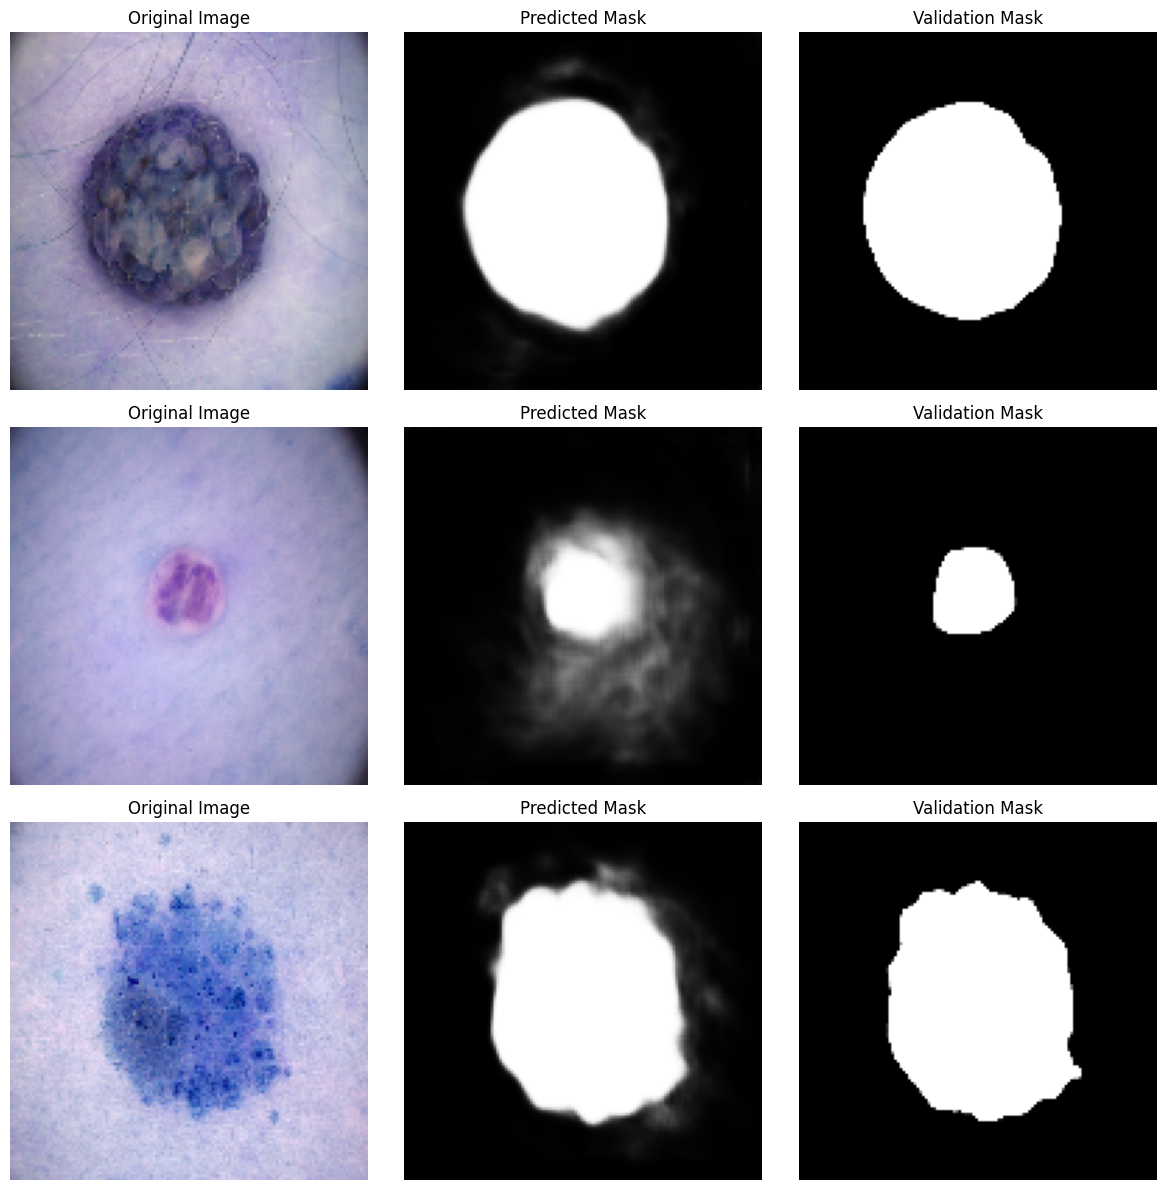

In [ ]:
import matplotlib.pyplot as plt
import math

pred_masks = model.predict(val_images)

num_images = 3

indices = np.random.choice(len(val_images), size=num_images, replace=False)

fig, axes = plt.subplots(num_images, 3, figsize=(12, 12))

for i, index in enumerate(indices):
    axes[i, 0].imshow(val_images[index])
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(pred_masks[index], cmap='gray')
    axes[i, 1].set_title('Predicted Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(val_masks[index], cmap='gray')
    axes[i, 2].set_title('Validation Mask')
    axes[i, 2].axis('off')

plt.tight_layout()

plt.show()


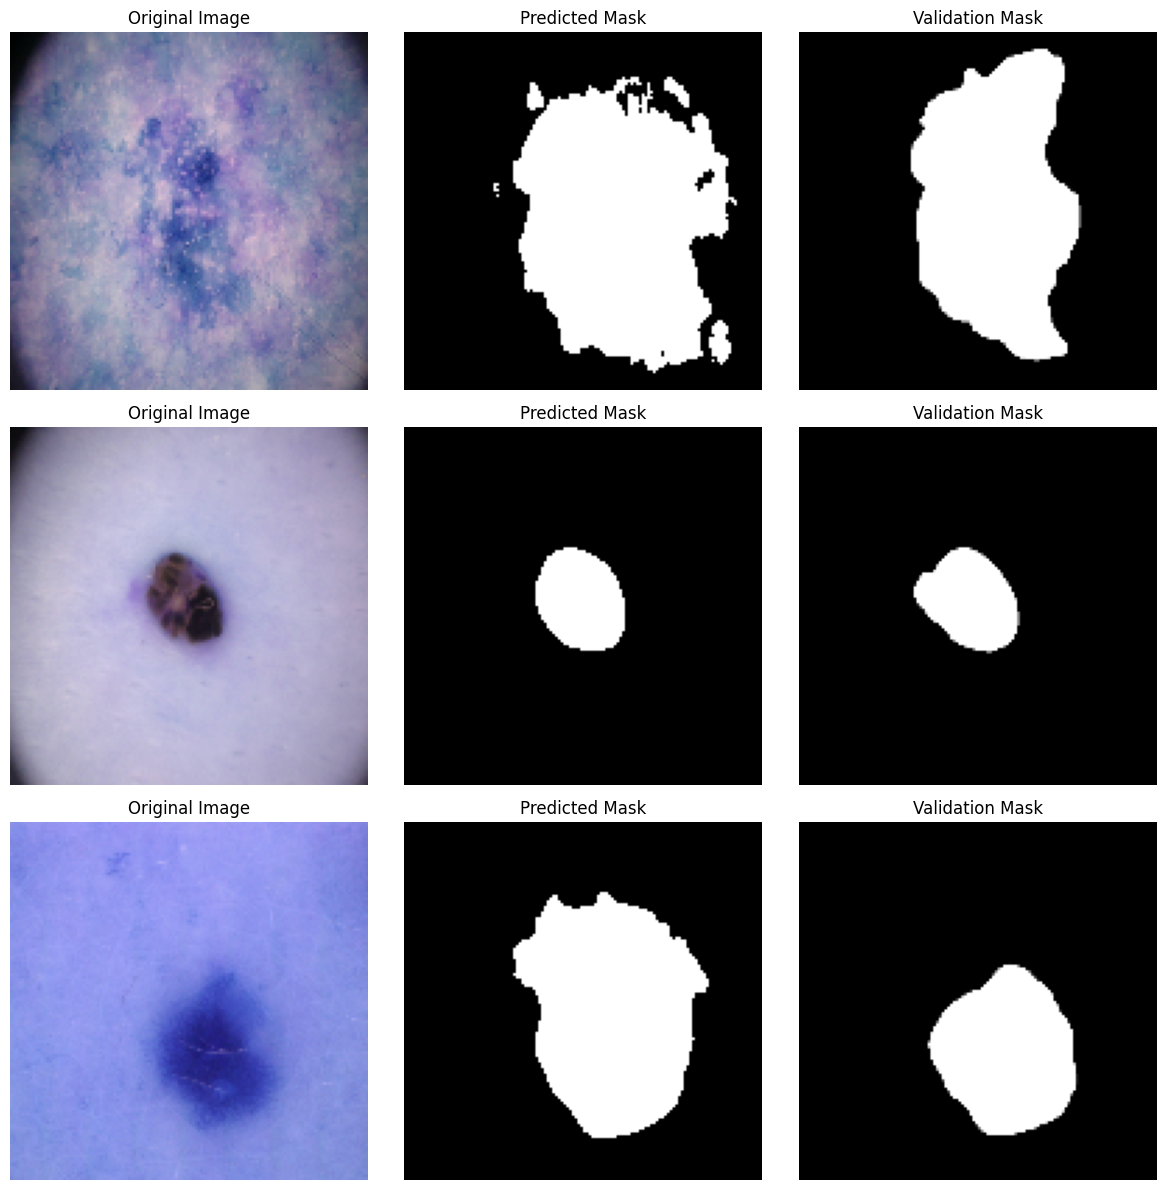

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure pred_masks are binary (0 or 1)
# If pred_masks are not already binary, threshold them
pred_masks = (pred_masks > 0.5).astype(np.uint8)

num_images = 3  # Number of images to display

# Randomly choose indices for visualization
indices = np.random.choice(len(val_images), size=num_images, replace=False)

fig, axes = plt.subplots(num_images, 3, figsize=(12, 12))

# Loop through the selected indices and display the images
for i, index in enumerate(indices):
    # Display the original image
    axes[i, 0].imshow(val_images[index])
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')  # Hide axes

    # Display the predicted mask (binary: 0 or 1)
    axes[i, 1].imshow(pred_masks[index], cmap='gray')
    axes[i, 1].set_title('Predicted Mask')
    axes[i, 1].axis('off')  # Hide axes

    # Display the validation mask
    axes[i, 2].imshow(val_masks[index], cmap='gray')
    axes[i, 2].set_title('Validation Mask')
    axes[i, 2].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


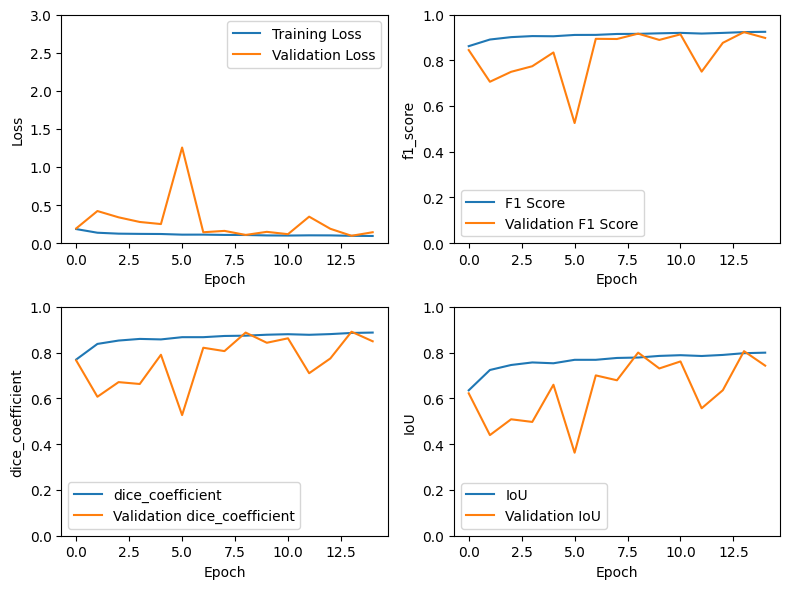

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['f1_score'], label='F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.ylim(0, 1)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['dice_coefficient'], label='dice_coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation dice_coefficient')
plt.xlabel('Epoch')
plt.ylabel('dice_coefficient')
plt.ylim(0, 1)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['iou_score'], label='IoU')
plt.plot(history.history['val_iou_score'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.ylabel('IoU')

plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/project/dataset/vgg_segment.h5")